In [1]:
import json
import collections

In [2]:
# Section 1: Read and Clean the Captions
def read_captions(file_path):
    """
    Read captions from the file and load them into a dictionary.
    """
    with open(file_path, 'r') as file:
        content = file.read()
    # Convert to JSON format by replacing single quotes with double quotes
    json_acceptable_string = content.replace("'", "\"")
    return json.loads(json_acceptable_string)

# Section 2: Tokenize Captions and Count Total Words
def get_total_words(captions_dict):
    """
    Iterate over captions and accumulate all words into a list.
    """
    total_words = []
    for key in captions_dict.keys():
        for caption in captions_dict[key]:
            total_words.extend(caption.split())
    return total_words

# Section 3: Calculate Word Frequency
def get_word_frequencies(words_list):
    """
    Compute the frequency of each word using a counter.
    """
    counter = collections.Counter(words_list)
    return dict(counter)

# Section 4: Filter Common Words by Frequency Threshold
def filter_common_words(freq_dict, threshold=10):
    """
    Filter out words that appear fewer times than the threshold.
    """
    # Sort words by frequency in decreasing order and filter by threshold
    sorted_freq = sorted(freq_dict.items(), reverse=True, key=lambda x: x[1])
    return [word for word, freq in sorted_freq if freq > threshold]


# Step 1: Read and process captions
captions = read_captions("tokens_clean.txt")

# Step 2: Tokenize captions and get total words
total_words = get_total_words(captions)
print("Total Words = %d" % len(total_words))

# Step 3: Calculate word frequencies
word_freqs = get_word_frequencies(total_words)
print("Number of unique words = %d" % len(word_freqs))

# Step 4: Filter common words with frequency > threshold
common_words = filter_common_words(word_freqs, threshold=10)
print("Number of common unique words = %d" % len(common_words))


Total Words = 1955246
Number of unique words = 18079
Number of common unique words = 5136


In [6]:
# Section 1: Read Training and Testing Image Names
def read_image_files(train_file, test_file):
    """
    Read image file names from the specified training and testing files.
    """
    with open(train_file, 'r') as file:
        train_data = file.read().splitlines()  # Read and split lines

    with open(test_file, 'r') as file:
        test_data = file.read().splitlines()  # Read and split lines

    return train_data, test_data

# Section 2: Extract Image IDs from Filenames
def extract_image_ids(image_list):
    """
    Extract image IDs from a list of image file names.
    """
    return [image.split('.')[0] for image in image_list]

# Section 3: Prepare Training Captions Dictionary
def prepare_training_captions(train_ids, content):
    """
    Prepare a dictionary of training image IDs and their corresponding captions.
    """
    train_captions = {}
    for image_id in train_ids:
        train_captions[image_id] = []
        for caption in content[image_id]:
            # Add start and end sequence tokens to each caption
            cap_to_append = "startseq " + caption + " endseq"
            train_captions[image_id].append(cap_to_append)
    return train_captions


# Step 1: Read image file names from training and testing datasets
train_data, test_data = read_image_files("flickr30k_train.txt", "flickr30k_test.txt")

# Step 2: Extract image IDs
train_ids = extract_image_ids(train_data)
test_ids = extract_image_ids(test_data)

# Step 3: Prepare the training content dictionary
train_content = prepare_training_captions(train_ids, captions)

# Example output for verification
train_content['1040426962'] # Display captions for a specific image ID


['startseq a man is cooking what appears to be green beans in a grill basket on a grill with a yellow lab standing by him while someone takes a picture from above  endseq',
 'startseq a man and his dog are grilling green beans on a grill  endseq',
 'startseq a man grilling vegetables on a patio with his dog  endseq',
 'startseq a man and a dog grilling green beans  endseq',
 'startseq guy and his dog cooking outside endseq']

In [11]:
# Section 1: Import Libraries
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from tqdm import tqdm
from time import time

# Section 2: Load ResNet50 Model
model = ResNet50(weights='imagenet', input_shape=(224, 224, 3))
model.summary()  # Display model architecture

# Create a new model that outputs the second to last layer
model_new = Model(model.input, model.layers[-2].output)


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


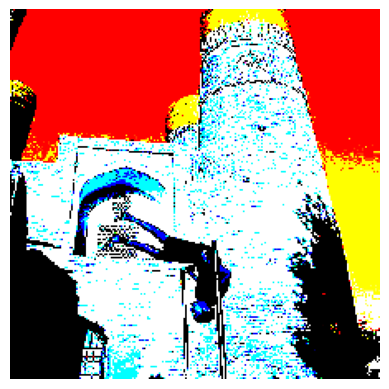

In [15]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img_path):
    # Load the image and resize it to 224x224 pixels
    img = load_img(img_path, target_size=(224, 224))
    
    # Convert the image to a NumPy array
    img = img_to_array(img)
    
    # Add an extra dimension to make it batch-compatible (4D tensor)
    img = np.expand_dims(img, axis=0)
    
    # Normalize the image according to ResNet50 requirements
    img = preprocess_input(img)

    return img

# Section 4: Display Preprocessed Image
img = preprocess_image(r"C:\Users\91900\Desktop\Project\Image Captioning\flickr30k_images\flickr30k_images\flickr30k_images\81641.jpg")
# Check if the image was loaded correctly
if img is not None:
    print(img.shape)  # Print the shape of the preprocessed image
    plt.imshow(img[0])
    plt.axis('off')
    plt.show()
else:
    print("Error: The image was not loaded properly.")


In [16]:
# Section 5: Image Encoding Function
def encode_image(img_path):
    """
    Encode the image to obtain its feature vector.
    """
    img = preprocess_image(img_path)
    feature_vector = model_new.predict(img)
    return feature_vector.reshape((-1,))  # Flatten the feature vector

# Section 6: Save Encodings to File
def save_encodings(encodings, file_path):
    """
    Save the encodings to a specified file using pickle.
    """
    with open(file_path, 'wb') as f:
        pickle.dump(encodings, f)

# Section 7: Encode Images with Progress Tracking
def encode_images_with_progress(image_list, save_interval=100, save_path="train_encoding.pkl"):
    """
    Encode a list of images and save encodings at regular intervals.
    """
    encodings = {}
    start_time = time()

    for index, image_id in tqdm(enumerate(image_list), total=len(image_list), desc="Encoding Images"):
        image_path = os.path.join("C:/Users/91900/Desktop/Project/Image Captioning/flickr30k_images/flickr30k_images/flickr30k_images/", image_id + ".jpg")
        encodings[image_id] = encode_image(image_path)

        # Save encodings at regular intervals
        if (index + 1) % save_interval == 0:
            save_encodings(encodings, save_path)
            print(f"Encodings saved at step {index + 1}")

    # Final save after loop completes
    save_encodings(encodings, save_path)
    end_time = time()
    print(f"Total time taken: {end_time - start_time} seconds")
    print(f"Final encodings saved to {save_path}")

# Example usage for training data
# encode_images_with_progress(train_data, save_interval=100, save_path="train_encoding.pkl")
# encode_images_with_progress(test_data, save_interval=100, save_path="test_encoding.pkl")

# Section 8: Load Encodings from File
def load_encodings(file_path):
    """
    Load encodings from a pickle file.
    """
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Load train and test encodings
train_encoding = load_encodings("train_encoding.pkl")
test_encoding = load_encodings("test_encoding.pkl")

# Section 9: Verify Loaded Encodings
print(f"Number of training encodings: {len(train_encoding)}")
print(f"Number of testing encodings: {len(test_encoding)}")


Number of training encodings: 15200
Number of testing encodings: 1000


In [23]:
# Section 1: Create Word-to-Index and Index-to-Word Mappings
word_to_index = {}  # Mapping from words to their corresponding indices
index_to_word = {}  # Mapping from indices to their corresponding words

# Populate mappings
for i, word in enumerate(total_words):
    word_to_index[word] = i + 1  # Start index from 1
    index_to_word[i + 1] = word

# Print mappings information
print(f"Total unique words in vocabulary: {len(index_to_word)}")  # Total unique words
print(f"Word at index 5: '{index_to_word[5]}'")    # Example word at index 5
print(f"Index of the word 'is': {word_to_index['is']}")  # Index of the word 'is'

# Section 2: Add Start and End Sequence Tokens to Mappings
start_seq_index = len(word_to_index) + 1
end_seq_index = start_seq_index + 1

index_to_word[start_seq_index] = 'startseq'
word_to_index['startseq'] = start_seq_index

index_to_word[end_seq_index] = 'endseq'
word_to_index['endseq'] = end_seq_index

# Vocabulary size including startseq and endseq
VOCAB_SIZE = len(word_to_index) + 1  # +1 for padding
print(f"Vocabulary size (including startseq and endseq): {VOCAB_SIZE}")

# Section 3: Save Mappings to Disk
import pickle

# Save the word-to-index mapping
with open("word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

# Save the index-to-word mapping
with open("idx_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

# Section 4: Get Maximum Length of Captions
max_len = 0  # Initialize maximum length variable

# Calculate maximum caption length
for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

print(f"Maximum length of captions: {max_len}")   # Print maximum length of captions


Total unique words in vocabulary: 1955246
Word at index 5: 'shaggy'
Index of the word 'is': 1955195
Vocabulary size (including startseq and endseq): 18082
Maximum length of captions: 80


In [24]:
# Load GloVe embeddings
embeddings_index = {}
embedding_dim = 50
with open("glove.6B.50d.txt", encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]  # The word
        coefs = np.array(values[1:], dtype='float')  # The embedding vector
        embeddings_index[word] = coefs  # Add to embeddings index

# Example access to an embedding
print(f"GloVe embedding for 'bridge': {embeddings_index.get('bridge')}")  # Example access to an embedding

# Section 6: Create Embedding Matrix
embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))  # Initialize embedding matrix

# Fill embedding matrix with GloVe embeddings
for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Ensure the index does not exceed the embedding matrix size
        if i < embedding_matrix.shape[0]:
            embedding_matrix[i] = embedding_vector  # Populate embedding matrix with found vectors
        else:
            continue

# Print shape of the embedding matrix
print(f"Shape of the embedding matrix: {embedding_matrix.shape}")

GloVe embedding for 'bridge': [ 0.63036   1.2631    0.30301  -0.23067  -0.78391   0.37984  -0.52663
  0.063602  0.040054 -0.82701  -0.61943   0.22793  -0.96129  -0.4248
 -1.0858    0.32512   0.78584   0.098795 -0.31272   0.061601  0.67796
 -0.38947  -1.1156   -0.18384   0.60073  -1.2443    0.30368   0.80471
  0.095064 -1.1309    2.4259   -0.46297   0.56154   0.016516  0.11984
  0.056484  0.69549  -0.39013  -0.15385   0.85811  -0.30979  -0.62073
  0.35284  -0.63784  -0.92062   0.1111    0.056533 -1.2124    0.18065
 -1.1193  ]
Shape of the embedding matrix: (18082, 50)


In [25]:
# Section 1: Define Model Architecture
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Add
from keras.models import Model

# Input layer for image features (2048-dimensional)
img_input = Input(shape=(2048,))

# Image feature processing
img_dropout = Dropout(0.3)(img_input)  # Dropout for regularization
img_dense = Dense(256, activation='relu')(img_dropout)  # Dense layer for feature extraction

# Input layer for captions (variable length based on max_len)
cap_input = Input(shape=(max_len,))

# Caption processing
cap_embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=50, mask_zero=True)(cap_input)  # Embedding layer
cap_dropout = Dropout(0.3)(cap_embedding)
cap_lstm = LSTM(256)(cap_dropout) 

# Section 2: Combine Image and Caption Features
decoder_input = Add()([img_dense, cap_lstm]) 
decoder_dense = Dense(256, activation='relu')(decoder_input) 
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder_dense)  

# Create the combined model
model = Model(inputs=[img_input, cap_input], outputs=outputs)  # Define model structure
model.summary()  # Print model summary


# Set embedding layer weights and freeze for training
model.layers[2].set_weights([embedding_matrix])  # Set weights to embedding matrix
model.layers[2].trainable = False  # Freeze embedding layer

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam")  # Compile model with loss function and optimizer

# Section 3: Create Data Loader
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_generator(train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []  # Initialize lists to hold training data
    n = 0  # Counter for batches

    while True:  # Infinite loop for continuous data generation
        for imageID, cap_list in train_content.items():  # Iterate over training content
            n += 1  # Increment batch counter

            image = train_encoding[imageID]  # Get image features

            for caption in cap_list:  # Iterate over captions
                # Convert caption to sequence of indices
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                # Generate input-output pairs
                for i in range(1, len(idx_seq)):
                    xi = idx_seq[0:i]  # Input sequence of words
                    yi = idx_seq[i]  # Expected next word

                    # Pad input sequences to ensure equal length
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]  # Get first row only
                    # Convert expected word to one-hot encoded vector
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    # Append data to lists
                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                # Yield batches of data
                if n == batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]  # Yield batch
                    X1, X2, y = [], [], []  # Reset lists for next batch
                    n = 0  # Reset batch counter


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 50)       904100      ['input_7[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_6[0][0]']                
                                                                                            

In [ ]:
# Section 4: Train the Model
epochs = 15  # Number of training epochs
batch_size = 5  # Size of each training batch
steps = len(train_content) // batch_size  # Calculate steps per epoch

for epoch in range(epochs):  # Iterate over epochs
    # Create an instance of the data generator for each epoch
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    
    # Train the model using the generator
    model.fit(generator, steps_per_epoch=steps)  # Fit the model to the generated data
    
    # Save the model after each epoch
    model.save(f'model_epoch_{epoch}.h5')  # Save the model with epoch number in filename


In [38]:
import numpy as np
from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pickle import load

# Load the model and the necessary data
model = load_model('model_14.h5')

# Load the encoded features for test images
with open("test_encoding.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

# Load the word-to-index and index-to-word mappings
with open("word_to_idx.pkl", "rb") as word_to_index_file:
    word_to_index = load(word_to_index_file)

with open("idx_to_word.pkl", "rb") as index_to_word_file:
    index_to_word = load(index_to_word_file)

max_len = 34  # Set this to your maximum length of captions

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Adjust size as per your model's requirement
    img = img_to_array(img)  # Convert to numpy array
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Reshape for the model
    return img

# Function to generate caption from the image features
def generate_caption(photo):
    in_text = 'startseq'
    for _ in range(max_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final_caption = ' '.join(in_text.split()[1:-1])  # Remove 'startseq' and 'endseq'
    return final_caption

# Main function to predict captions
def predict_caption(image_path):
    # Load and preprocess the image
    img = load_and_preprocess_image(image_path)

    # Extract features using the encoding_test (assuming you have features ready)
    image_name = image_path.split('/')[-1]  # Adjust if needed
    if image_name in encoding_test:
        photo = encoding_test[image_name]  # Get the encoded features
        caption = generate_caption(np.array([photo]))  # Generate caption
        return caption
    else:
        return "Image features not found."

# Example usage
image_path = r"C:\Users\91900\Downloads\child.jpg" # Update this path
caption = predict_caption(image_path)
print(f"Predicted Caption: {caption}")


Predicted Caption: Image features not found.


In [31]:
import numpy as np
import tkinter as tk
from tkinter import filedialog
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pickle import load
from PIL import Image, ImageTk

# Load the pre-trained model and necessary data
model = load_model('model_14.h5')

# Load word index mappings
with open("word_to_idx.pkl", "rb") as file:
    word_to_index = load(file)
with open("idx_to_word.pkl", "rb") as file:
    index_to_word = load(file)

# Load encoded test features
with open("test_encoding.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)


print(encoding_test.keys())


dict_keys(['1007129816', '1009434119', '101362133', '102617084', '10287332', '1039637574', '1043819504', '1043910339', '1044798682', '1071201387', '107969134', '1080230428', '1082250005', '1089059626', '109260218', '109656696', '1104087374', '110671448', '111497985', '1131056918', '1144865997', '1153704539', '1159381599', '1167908324', '1181708011', '118865844', '121178216', '12252043', '1229536824', '123314995', '1250181412', '1253095131', '1255504166', '1258913059', '1281282435', '1287704027', '1295476404', '129860826', '130063845', '1313869424', '1313961775', '133010954', '1332208215', '1333888922', '1341077576', '1351500610', '136581487', '136693281', '1368082221', '139245992', '1395410911', '1396064003', '1397344877', '1404832008', '1408554531', '14133592', '1414911626', '1417882092', '1433088025', '14559446', '1459582913', '1463072715', '146906547', '1489286545', '150411291', '151970521', '1526325728', '155210731', '157910841', '1579198375', '1579206585', '157955034', '160792599'

In [53]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, add
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
from PIL import Image
import glob

# 1. Load and Preprocess Data
def load_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = np.array(img)
    if img.shape[-1] == 4:  # RGBA images
        img = img[..., :3]
    img = np.expand_dims(img, axis=0)
    return img / 255.0  # Normalize

def load_flickr30k_data(image_folder, captions_file):
    # Load the captions file
    captions = pd.read_csv(captions_file)  # Assuming the CSV has 'image_name' and 'comment' columns
    
    # Use groupby to combine multiple captions per image
    unique_images = captions.groupby('image_name')['comment'].apply(lambda x: ' '.join(x)).reset_index()

    # Create image paths for unique images
    image_paths = [os.path.join(image_folder, img) for img in unique_images['image_name']]
    
    # Captions combined for each unique image
    combined_captions = unique_images['comment'].values
    
    return image_paths, combined_captions

image_folder = r'C:\Users\91900\Desktop\Project\Image Captioning\flickr30k_images\flickr30k_images\flickr30k_images'
captions_file = r'C:\Users\91900\Desktop\Project\Image Captioning\flickr30k_images\captions.txt'

# Load image paths and combined captions
image_paths, captions = load_flickr30k_data(image_folder, captions_file)
 # Assumes a dataset with columns 'image_path' and 'caption'
# image_paths = captions_data['image_path'].values
# captions = captions_data['caption'].values

# Split data into train and test sets
train_img_paths, test_img_paths, train_captions, test_captions = train_test_split(image_paths, captions, test_size=0.2, random_state=42)


# 2. Preprocess Text (Captions)
def preprocess_text(captions, max_vocab_size=5000, max_length=40):
    tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<unk>")
    tokenizer.fit_on_texts(captions)
    vocab_size = len(tokenizer.word_index) + 1  # Extra for padding
    sequences = tokenizer.texts_to_sequences(captions)
    sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return sequences, tokenizer, vocab_size

train_sequences, tokenizer, vocab_size = preprocess_text(train_captions)

In [56]:
# 3. Feature Extraction Using EfficientNetB0
def build_image_model():
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    image_input = base_model.input
    image_features = base_model.layers[-1].output
    image_model = Model(inputs=image_input, outputs=image_features)
    return image_model

image_model = build_image_model()

In [57]:
from tensorflow.keras.preprocessing.text import Tokenizer



def generate_caption(model, tokenizer, image_features, max_length):
    caption = ['<start>']
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        prediction = model.predict([image_features, sequence], verbose=0)
        predicted_word = tokenizer.index_word[np.argmax(prediction)]
        caption.append(predicted_word)
        if predicted_word == '<end>':
            break
    return ' '.join(caption)


In [58]:
# Example usage
new_image_path = r"C:\Users\91900\Downloads\child.jpg"
new_image_features = image_model.predict(load_image(new_image_path))
generated_caption = generate_caption(model, tokenizer, new_image_features, train_sequences.shape[1])
print("Generated Caption:", generated_caption)

1/1 [==============================] - 5s 5s/step


ValueError: in user code:

    File "c:\Users\91900\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\91900\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\91900\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\91900\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "c:\Users\91900\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\91900\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\input_spec.py", line 296, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 2048), found shape=(None, 7, 7, 1280)
